<a href="https://colab.research.google.com/github/poandpo/final_project/blob/main/AI_06_%EC%9E%84%EC%B1%84%EC%9D%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 필요한 모듈

In [ ]:
!pip install sentence_transformers
!pip install mxnet
!pip install transformers==3 
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install torch
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

     |████████████████████████████████| 78 kB 4.6 MB/s 
     |████████████████████████████████| 3.4 MB 18.7 MB/s 
     |████████████████████████████████| 6.8 MB 36.9 MB/s 
     |████████████████████████████████| 1.2 MB 51.0 MB/s 
     |████████████████████████████████| 67 kB 5.7 MB/s 
     |████████████████████████████████| 895 kB 57.5 MB/s 
     |████████████████████████████████| 3.3 MB 60.4 MB/s 
     |████████████████████████████████| 596 kB 53.8 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=120999 sha256=2c7d8d0e830f65a6ad9f6bfc81f33103e10b8173995f8fdce201742eb667607e
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 47.3 MB 63.7 MB/s 
  A

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
import time
import tensorflow_datasets as tfds
import tensorflow as tf
from numpy import dot
from numpy.linalg import norm
import urllib.request
from sentence_transformers import SentenceTransformer
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
from tqdm import tqdm, tqdm_notebook
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

# 데이터 불러오기 & 확인

깃헙에서 올린 파일 가져올때는 public으로 해놔야 가져옴 아니면 HTTPError 404 오류 뜸(당연한 건데,,)

In [ ]:
path1 = 'https://raw.githubusercontent.com/poandpo/project-4/main/%EA%B0%90%EC%84%B1%EB%8C%80%ED%99%94%EB%A7%90%EB%AD%89%EC%B9%98(%EC%B5%9C%EC%A2%85%EB%8D%B0%EC%9D%B4%ED%84%B0)_Training.csv'
path2 = 'https://raw.githubusercontent.com/poandpo/project-4/main/%EA%B0%90%EC%84%B1%EB%8C%80%ED%99%94%EB%A7%90%EB%AD%89%EC%B9%98_Validation.csv'
path3 = 'https://raw.githubusercontent.com/poandpo/final_project/main/%EC%9B%B0%EB%8B%88%EC%8A%A4_%EB%8C%80%ED%99%94_%EC%8A%A4%ED%81%AC%EB%A6%BD%ED%8A%B8_%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%85%8B(%EB%B3%84).csv'
data_1 = pd.read_csv(path1, delimiter= ',')
data_2 = pd.read_csv(path2, delimiter= ',')
data_3 = pd.read_csv(path3, delimiter= ',')

In [ ]:
data_1.head()

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,44164,청년,남성,"연애, 결혼, 출산",해당없음,기쁨,신이 난,아내가 드디어 출산하게 되어서 정말 신이 나.,아내분이 출산을 하시는군요. 정말 축하드려요.,아 지금 정말 신이 나.,잘 된 일이네요.,아기가 점점 클게 벌써 기대가 되네. 내가 많이 놀아줘야지.,좋은 아빠가 되실 거 같아요. 진심으로 축하드려요.,NaN,NaN
1,3926,노년,남성,"건강, 죽음",만성질환 유,불안,스트레스 받는,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,약 종류가 많아 번거로우시겠어요.,건강할 때 관리 좀 잘할걸 하는 생각이 들더라고.,현재 상황에서 변화를 주기 위해 어떻게 하면 될까요?,약을 잘 챙겨 먹고 나을 수 있도록 노력해야지.,약을 잘 챙겨 먹어 건강해지시길 바랄게요.,NaN,NaN
2,50882,청소년,여성,학업 및 진로,해당없음,당황,당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,고등학교 수업이 중학교 때와는 다르게 갑자기 어려워서 당황스러우시군요.,아직 학기 초인데 내가 수업에 잘 따라갈 수 있을지 걱정돼.,이 상황에서 할 수 있는 게 어떤 것이 있을까요?,중학교 수업을 들을 때보다 훨씬 더 열심히 할 거야.,수업을 어떤 방식으로 열심히 듣는게 좋을까요?,선생님이 강조하신 부분을 필기하고 집에서 매일 수업 내용을 복습하려고 해.,열심히 해서 좋은 결과가 있었으면 좋겠어요.
3,31303,노년,남성,재정,만성질환 무,기쁨,신이 난,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,재취업 후 첫 월급이라 정말 기쁘시겠어요.,퇴직 후 다시는 돈을 못 벌 줄 알았는데 이렇게 월급으로 가족에게 맛있는 밥을 살 ...,이 기분을 유지하려면 어떻게 해야 할까요?,회사생활을 열심히 해서 계속 월급을 받을거야!,계속 원하시는 대로 회사생활이 이어지길 바랄게요.,NaN,NaN
4,47200,노년,여성,재정,만성질환 유,기쁨,안도,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,기분 좋으시겠어요. 앞으로는 어떻게 하실 생각이신가요?,빚도 다 갚았으니 당분간은 아무 생각도 안 하며 살고 싶어.,빚도 다 갚았으니 당분간은 아무 생각도 안 하며 살고 싶으시군요.,NaN,NaN,NaN,NaN


In [ ]:
data_1.shape, data_2.shape

((40879, 15), (5130, 15))

In [ ]:
print(data_3.shape)
data_3.head() # 특이사항, 추가발화 2개 삭제 

(5231, 4)


,구분,유저,챗봇,Unnamed: 3
0,감정/감정조절이상,제 감정이 이상해진 것 같아요. 남편만 보면 화가 치밀어 오르고 감정 조절이 안되요.,감정이 조절이 안 될 때만큼 힘들 때는 없는 거 같아요.,NaN
1,감정/감정조절이상,더 이상 내 감정을 내가 컨트롤 못 하겠어.,저도 그 기분 이해해요. 많이 힘드시죠?,NaN
2,감정/감정조절이상,하루종일 오르락내리락 롤러코스터 타는 기분이에요.,"그럴 때는 밥은 잘 먹었는지, 잠은 잘 잤는지 체크해보는 것도 좋아요.",NaN
3,감정/감정조절이상,꼭 롤러코스터 타는 것 같아요.,NaN,NaN
4,감정/감정조절이상,롤러코스터 타는 것처럼 기분이 왔다 갔다 해요.,NaN,NaN


In [ ]:
data_1.isnull().sum()

번호            0
연령            0
성별            0
상황키워드         0
신체질환          0
감정_대분류        0
감정_소분류        0
사람문장1         0
시스템응답1        0
사람문장2         0
시스템응답2        0
사람문장3      9820
시스템응답3     9820
사람문장4     39407
시스템응답4    39517
dtype: int64

In [ ]:
data_2.isnull().sum()

번호           0
연령           0
성별           0
상황키워드        0
신체질환         0
감정_대분류       0
감정_소분류       0
사람문장1        0
시스템응답1       0
사람문장2        0
시스템응답2       0
사람문장3     1256
시스템응답3    1256
사람문장4     4979
시스템응답4    4994
dtype: int64

# 데이터 합치기

In [ ]:
df_1 = data_1[['감정_대분류','감정_소분류','사람문장1', '시스템응답1']]
df_2 = data_2[['감정_대분류','감정_소분류','사람문장1', '시스템응답1']]
half_df = pd.concat([df_1,df_2])

In [ ]:
half_df['감정_대분류'].unique()

array(['기쁨', '불안', '당황', '슬픔', '분노', '상처', '불안 ', '기쁨 '], dtype=object)

In [ ]:
# data_3에 맞게 수정
half_df.loc[ half_df['감정_대분류'] == '기쁨','감정_대분류'] = '즐거움'
half_df.loc[ half_df['감정_대분류'] == '기쁨 ', '감정_대분류'] = '즐거움'
half_df.loc[ half_df['감정_대분류'] == '불안', '감정_대분류'] = '불안감'
half_df.loc[ half_df['감정_대분류'] == '불안 ', '감정_대분류'] = '불안감'
## half_df['감정_대분류'] == '상처' --> 수정
half_df.loc[(half_df['감정_대분류'] == '상처') & (half_df['감정_소분류']== '억울한'), '감정_대분류'] = '억울함'
half_df.loc[(half_df['감정_대분류'] == '상처') & (half_df['감정_소분류']== '배신당한'), '감정_대분류'] = '배신감'
half_df.loc[(half_df['감정_대분류'] == '상처') & (half_df['감정_소분류']== '괴로워하는'), '감정_대분류'] = '괴로움'
half_df.loc[(half_df['감정_대분류'] == '상처') & (half_df['감정_소분류']== '충격 받은'), '감정_대분류'] = '충격'
half_df.loc[(half_df['감정_대분류'] == '상처') & (half_df['감정_소분류']== '버려진'), '감정_대분류'] = '고독감'
half_df.loc[(half_df['감정_대분류'] == '상처') & (half_df['감정_소분류']== '고립된'), '감정_대분류'] = '외로움'
half_df.loc[(half_df['감정_대분류'] == '상처') & (half_df['감정_소분류']== '질투하는'), '감정_대분류'] = '질투'
half_df.loc[(half_df['감정_대분류'] == '상처') & (half_df['감정_소분류']== '가난한, 불우한'), '감정_대분류'] = '배경/경제적문제/가난'
half_df.loc[(half_df['감정_대분류'] == '상처') & (half_df['감정_소분류']== '조심스러운'), '감정_대분류'] = '모호함'
half_df.loc[(half_df['감정_대분류'] == '상처') & (half_df['감정_소분류']== '상처'), '감정_대분류'] = '속상함'
half_df.loc[(half_df['감정_대분류'] == '상처') & (half_df['감정_소분류']== '희생된'), '감정_대분류'] = '속상함'
half_df.drop(labels= '감정_소분류', axis= 1, inplace= True)
## '감정/' 더하기
half_df['감정_대분류'] = '감정/'+ half_df['감정_대분류']
half_df.loc[ half_df['감정_대분류'] == '감정/배경/경제적문제/가난', '감정_대분류'] = '배경/경제적문제/가난'

#데이터 합치기
data_3.drop(labels= 'Unnamed: 3', axis= 1, inplace= True )
half_df.columns = ['구분', '유저', '챗봇']
df = pd.concat([half_df,data_3])
## 인텍스 정렬
df = df.reset_index(drop=True)


In [ ]:
print(df.shape)
df.head(5)

(51240, 3)


,구분,유저,챗봇
0,감정/즐거움,아내가 드디어 출산하게 되어서 정말 신이 나.,아내분이 출산을 하시는군요. 정말 축하드려요.
1,감정/불안감,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,약 종류가 많아 번거로우시겠어요.
2,감정/당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,고등학교 수업이 중학교 때와는 다르게 갑자기 어려워서 당황스러우시군요.
3,감정/즐거움,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,재취업 후 첫 월급이라 정말 기쁘시겠어요.
4,감정/즐거움,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,기분 좋으시겠어요. 앞으로는 어떻게 하실 생각이신가요?


# 전처리 과정

In [ ]:
df.duplicated().sum(), data_3.duplicated().sum()

(1282, 16)

In [ ]:
df.drop_duplicates(inplace= True)

In [ ]:
df['챗봇'].isnull().sum()

4181

In [ ]:
df=df.dropna()

In [ ]:
df['챗봇'].isnull().sum()

0

In [ ]:
#labelencoder로 바꾸기
np.random.seed(3)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
enc = le.fit_transform(df['구분'])
df['구분'] = enc

In [ ]:
print(df.shape)
df.head()

(45777, 3)


,구분,유저,챗봇
0,74,아내가 드디어 출산하게 되어서 정말 신이 나.,아내분이 출산을 하시는군요. 정말 축하드려요.
1,41,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,약 종류가 많아 번거로우시겠어요.
2,25,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,고등학교 수업이 중학교 때와는 다르게 갑자기 어려워서 당황스러우시군요.
3,74,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,재취업 후 첫 월급이라 정말 기쁘시겠어요.
4,74,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,기분 좋으시겠어요. 앞으로는 어떻게 하실 생각이신가요?


In [ ]:
df['구분'].nunique()

356

In [ ]:
questions = []
for sentence in df['유저']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    questions.append(sentence)

In [ ]:
answers = []
for sentence in df['챗봇']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    try: 
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = sentence.strip()
        answers.append(sentence)
    except TypeError as e:
        pass

In [ ]:
# 단어 집합 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

INFO:absl:SubwordTextEncoder build: trying min_token_count 36319
INFO:absl:SubwordTextEncoder build: trying min_token_count 18159
INFO:absl:SubwordTextEncoder build: trying min_token_count 9079
INFO:absl:SubwordTextEncoder build: trying min_token_count 4539
INFO:absl:SubwordTextEncoder build: trying min_token_count 2269
INFO:absl:SubwordTextEncoder build: trying min_token_count 1134
INFO:absl:SubwordTextEncoder build: trying min_token_count 567
INFO:absl:SubwordTextEncoder build: trying min_token_count 283
INFO:absl:SubwordTextEncoder build: trying min_token_count 141
INFO:absl:SubwordTextEncoder build: trying min_token_count 70
INFO:absl:SubwordTextEncoder build: trying min_token_count 35
INFO:absl:SubwordTextEncoder build: trying min_token_count 17
INFO:absl:SubwordTextEncoder build: trying min_token_count 26
INFO:absl:SubwordTextEncoder build: trying min_token_count 21
INFO:absl:SubwordTextEncoder build: trying min_token_count 23
INFO:absl:SubwordTextEncoder build: trying min_token_

In [ ]:
# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
VOCAB_SIZE = tokenizer.vocab_size + 2

In [ ]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : [8276]
종료 토큰 번호 : [8277]
단어 집합의 크기 : 8278


In [ ]:
# 서브워드텍스트인코더 토크나이저의 .encode()와 .decode() 테스트해보기
# 임의의 입력 문장을 sample_string에 저장
sample_string = questions[20]

# encode() : 텍스트 시퀀스 --> 정수 시퀀스
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode() : 정수 시퀀스 --> 텍스트 시퀀스
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

정수 인코딩 후의 문장 [5407, 1975, 1938, 1469, 19, 4, 197, 3683, 1232, 2, 37, 91, 4617, 6480, 3234, 3044, 6, 34, 1]
기존 문장: 지난주에 주식이 폭락해서 너무 큰 손해를 봤어 .  어떻게 해야 좋을지 모르겠고 정신이 나갈 것 같아 .


In [ ]:
# 각 정수는 각 단어와 어떻게 mapping되는지 병렬로 출력
# 서브워드텍스트인코더는 의미있는 단위의 서브워드로 토크나이징한다. 띄어쓰기 단위 X 형태소 분석 단위 X
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

5407 ----> 지난주에 
1975 ----> 주식이 
1938 ----> 폭
1469 ----> 락
19 ----> 해서 
4 ----> 너무 
197 ----> 큰 
3683 ----> 손해를 
1232 ----> 봤어
2 ---->  .  
37 ----> 어떻게 
91 ----> 해야 
4617 ----> 좋을지 
6480 ----> 모르겠고 
3234 ----> 정신이 
3044 ----> 나갈 
6 ----> 것 
34 ----> 같아
1 ---->  .


In [ ]:
# 최대 길이를 40으로 정의
MAX_LENGTH = 40

# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)

  # 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs

In [ ]:
questions, answers = tokenize_and_filter(questions, answers)

In [ ]:
print('질문 데이터의 크기(shape) :', questions.shape)
print('답변 데이터의 크기(shape) :', answers.shape)

질문 데이터의 크기(shape) : (45777, 40)
답변 데이터의 크기(shape) : (45777, 40)


In [ ]:
questions[20]

array([8276, 5407, 1975, 1938, 1469,   19,    4,  197, 3683, 1232,    2,
         37,   91, 4617, 6480, 3234, 3044,    6,   34,    1, 8277,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], dtype=int32)

- 오늘까지 전처리, 패딩까지 끝내놓고
- 내일 트랜스포머, 바트임배딩을 이용한 해보기

# 모델 구현

## transformer 구현- 다시 복습

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model) 

  def get_config(self):
        config = super().get_config().copy()
        return config  

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])

    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    angle_rads = np.zeros(angle_rads.shape)
    angle_rads[:, 0::2] = sines
    angle_rads[:, 1::2] = cosines
    pos_encoding = tf.constant(angle_rads)
    pos_encoding = pos_encoding[tf.newaxis, ...]

    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [ ]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, key의 문장 길이)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
  return tf.maximum(look_ahead_mask, padding_mask)

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):

  # Q와 K의 곱. 어텐션 스코어 행렬.
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 스케일링
  # dk의 루트값으로 나눠준다.
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
  # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
  if mask is not None:
    logits += (mask * -1e9)

  # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
  # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  output = tf.matmul(attention_weights, value)

  return output, attention_weights

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    # d_model을 num_heads로 나눈 값.
    # 논문 기준 : 64
    self.depth = d_model // self.num_heads

    # WQ, WK, WV에 해당하는 밀집층 정의
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    # WO에 해당하는 밀집층 정의
    self.dense = tf.keras.layers.Dense(units=d_model)

  def get_config(self):
        config = super().get_config().copy()
        return config  


  # num_heads 개수만큼 q, k, v를 split하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
    # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
    # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 4. 헤드 연결(concatenate)하기
    # (batch_size, query의 문장 길이, d_model)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 5. WO에 해당하는 밀집층 지나기
    # (batch_size, query의 문장 길이, d_model)
    outputs = self.dense(concat_attention)

    return outputs

In [ ]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크 사용
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
#num_layer개 만큼 인코더 쌓고 마지막층에 행렬을 디코더로 보내주는 코드
def encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 인코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

  # 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")

  # 패딩 마스크(두번째 서브층)
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': look_ahead_mask # 룩어헤드 마스크
      })

  # 잔차 연결과 층 정규화
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
          'mask': padding_mask # 패딩 마스크
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [ ]:
def decoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 디코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [ ]:
def transformer(vocab_size, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

  # 인코더의 입력
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 디코더의 입력
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더의 패딩 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더의 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 디코더의 패딩 마스크(두번째 서브층)
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
  enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

  # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
  dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 다음 단어 예측을 위한 출력층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def get_config(self):
    config = {
    'd_model': self.d_model,
    'warmup_steps': self.warmup_steps,

     }
    return config
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

## transformer 챗봇 

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': answers[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:



# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=ea44a6c4548ba6626a251475e4edda3cf075c31d4dae0303043059f7d3bf9699
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil
Gen RAM Free: 25.4 GB  |     Proc size: 2.6 GB
GPU RAM Free: 15903MB | Used: 377MB | Util   2% | Total     16280MB


In [ ]:
D_MODEL = 256
NUM_LAYERS = 2
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

(1, 8278, 256)
(1, 8278, 256)


In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # 레이블의 크기는 (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS)

Epoch 1/50
716/716 [==============================] - 52s 60ms/step - loss: 1.9881 - accuracy: 0.0417
Epoch 2/50
716/716 [==============================] - 43s 60ms/step - loss: 1.4394 - accuracy: 0.0767
Epoch 3/50
716/716 [==============================] - 43s 60ms/step - loss: 1.2153 - accuracy: 0.0912
Epoch 4/50
716/716 [==============================] - 43s 60ms/step - loss: 1.0496 - accuracy: 0.1024
Epoch 5/50
716/716 [==============================] - 43s 60ms/step - loss: 0.9293 - accuracy: 0.1109
Epoch 6/50
716/716 [==============================] - 43s 60ms/step - loss: 0.8408 - accuracy: 0.1185
Epoch 7/50
716/716 [==============================] - 43s 60ms/step - loss: 0.7425 - accuracy: 0.1289
Epoch 8/50
716/716 [==============================] - 43s 60ms/step - loss: 0.6463 - accuracy: 0.1413
Epoch 9/50
716/716 [==============================] - 43s 60ms/step - loss: 0.5648 - accuracy: 0.1535
Epoch 10/50
716/716 [==============================] - 43s 60ms/step - loss: 0.493

Text(0.5, 0, 'Train Step')

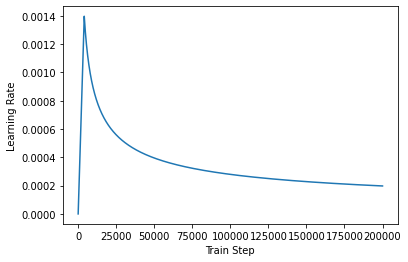

In [ ]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:
def preprocess_sentence(sentence):
  sentence = re.sub(r"([?.!,])", r"", sentence)
  sentence = sentence.strip()
  return sentence

In [ ]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)


    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)

In [ ]:
def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  #print('Input: {}'.format(sentence))
  print('chatbot: {}'.format(predicted_sentence))

  return predicted_sentence

# 건들지 마셈

In [ ]:
output = predict("엄마 때문에 너무 화나")

chatbot: 어머니 때문에 화가 나신 일이 있군요 .


In [ ]:
output = predict("자살생각이 계속 들어")

chatbot: 그런 생각이 드신 이유가 있나요 ?


In [ ]:
output = predict("대박이야")

chatbot: 대박이군요 .  무슨 일인가요 ?


In [ ]:
output = predict("취업때문에 너무 스트레스 받아")

chatbot: 취업 때문에 스트레스가 많으시군요 .  어떤 시험이었나요 ?


Layer PositionalEncoding has arguments in `__init__` and therefore must override `get_config`오류
: https://lsjsj92.tistory.com/598

## BERT 챗봇

In [ ]:
model_2 = SentenceTransformer('sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens')

Downloading:   0%|          | 0.00/574 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.06k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/731 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
df['embedding'] = df.apply(lambda row: model_2.encode(row.유저), axis = 1)

In [ ]:
def cos_sim(A, B):
  return dot(A, B)/(norm(A)*norm(B))

In [ ]:
def return_answer(question):
    embedding = model_2.encode(question)
    df['score'] = df.apply(lambda x: cos_sim(x['embedding'], embedding), axis=1)
    re =df.loc[df['score'].idxmax()]['챗봇']
    print(re)

In [ ]:
return_answer('죽고싶다')

전문가와 상담을 받아보신 적이 있나요? 힘이 들 땐 도움을 받는 게 좋아요.


In [ ]:
return_answer('자살할래')

오늘은 삶의 그래프를 한번 그려보면 어때요? 늘 안 좋은 일만 있었던 건 아닐 거예요.


In [ ]:
return_answer('답이 없어') # 1

힘드신가 봐요. 무슨 일 있으세요?


In [ ]:
return_answer('집에 큰일이 생겼어') # 2

마음이 힘드시겠어요.


In [ ]:
return_answer('너무 힘들어') #3

많이 곤란하셨을 거 같아요.


In [ ]:
pip freeze > requirements.txt

## 다중분류 모델(Bert)

In [ ]:
device = torch.device("cuda:0") # #GPU 사용

In [ ]:
bertmodel, vocab = get_pytorch_kobert_model() #BERT 모델, Vocabulary 불러오기

/content/.cache/kobert_v1.zip[██████████████████████████████████████████████████]
/content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train, test = train_test_split(df, test_size= 0.2, random_state=1234)

In [ ]:
data_train = []
for a, label in zip(train['유저'], train['구분']):
    data1 = []
    data1.append(a)
    data1.append(str(label))

    data_train.append(data1)

data_test = []
for b, label2 in zip(test['유저'], test['구분']):
    data2 = []
    data2.append(b)
    data2.append(str(label2))

    data_test.append(data2)

In [ ]:
# koBERT 입력
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [ ]:
max_len = 20
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

#토큰화
tokenizer2 = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer2, vocab, lower=False)

data_train = BERTDataset(data_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(data_test, 0, 1, tok, max_len, True, False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=360,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
            
        return self.classifier(out)

In [ ]:
#BERT 모델 불러오기
model3 = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model3.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model3.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    
train_dataloader

In [ ]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model3.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model3(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model3.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    model3.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model3(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))


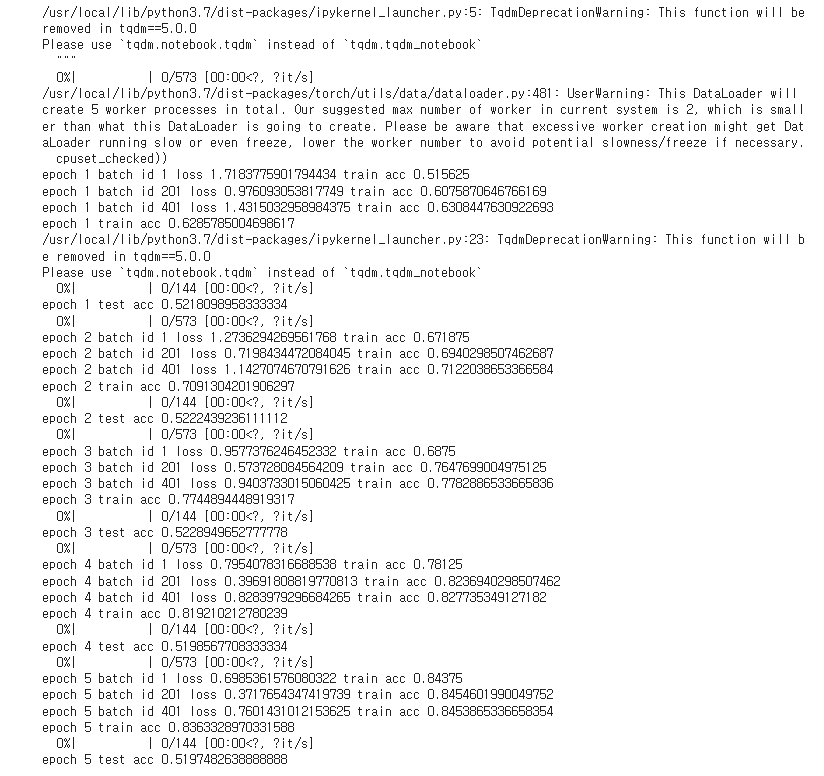

( 지금은 GPU 오류로 인해 안되고 있어 전에 모델 돌린 결과 올림)

In [ ]:
# 새로운 문장 테스트
tokenizer2 = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer2, vocab, lower=False)
bye =[20, 74 ,103,104, 108,110,111,112,113,114,115,118,119,124,133,135,137,140,141,142,151,170,173,174,175 ,176, 177, 179, 180, 181, 182, 183,184,185,186,187,188,189,190,191,192,197,199,200,201, 203, 205,207, 209, 213,214, 216, 220,221,222, 223, 227,231, 233,234,235,236,237,238,240,245,254,255, 256, 351,352,353,354,355]
famliy = [9, 34,92,93,94,120,121,122,123,125,126,127,128,129,130, 152,153,154,155,156,157,158,159,161,162,163]
violence = [131,170, 178]
youth= [246,247,248,249,250, 251]
work= [224, 225,226, 228,229, 230, 232]
def predict2(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model3.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model3(token_ids, valid_length, segment_ids)

        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) in bye
               print("오늘 대화 즐거웠어요. 다음에 또 대화해요 :)")
            elif np.argmax(logits) in family 
               print("당신에게 도움이 될만한 사이트입니다")    
               print("상담받아보세요:", "https://www.familynet.or.kr/web/lay1/program/S1T1C307/info/view.do")
               print("상담받아보세요", "http://www.nmhc.or.kr/ezboard.php?BID=board21&GID=root&sysop=&fm=&category=1&sido")
               print("자가 검진해보세요:", "http://www.mentalhealth.go.kr/portal/main/index.do")
            elif np.argmax(logits) in violence 
               print("당신에게 도움이 될만한 사이트입니다")    
               print("상담받아보세요:", "http://seoul1366.or.kr/new_html/sub02/body01.php")
               print("상담받아보세요", "http://www.nmhc.or.kr/ezboard.php?BID=board21&GID=root&sysop=&fm=&category=1&sido")
               print("자가 검진해보세요:", "http://www.mentalhealth.go.kr/portal/main/index.do")               
            elif np.argmax(logits) in youth 
               print("당신에게 도움이 될만한 사이트입니다")    
               print("상담받아보세요:", "https://www.kyci.or.kr/userSite/cooperation/list.asp?basicNum=1")
               print("상담받아보세요", "http://www.nmhc.or.kr/ezboard.php?BID=board21&GID=root&sysop=&fm=&category=1&sido")
               print("자가 검진해보세요:", "http://www.mentalhealth.go.kr/portal/main/index.do")  
            elif np.argmax(logits) in work
               print("당신에게 도움이 될만한 사이트입니다")    
               print("상담받아보세요:", "https://www.workdream.net/default/eap/covid.do?mCode=D005010000")
               print("상담받아보세요", "http://www.nmhc.or.kr/ezboard.php?BID=board21&GID=root&sysop=&fm=&category=1&sido")
               print("자가 검진해보세요:", "http://www.mentalhealth.go.kr/portal/main/index.do")     
            else
               print("당신에게 도움이 될만한 사이트입니다")    
               print("상담받아보세요", "http://www.nmhc.or.kr/ezboard.php?BID=board21&GID=root&sysop=&fm=&category=1&sido")
               print("자가 검진해보세요:", "http://www.mentalhealth.go.kr/portal/main/index.do")      

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


### '구분' 분류 하기

> 제외(마무리 인사)

20, 74,103,104, 108,110,111,112,113,114,115,118,119,124,133,135,137,140,141,142,151,170,173,174,175 ,176, 177, 179, 180, 181, 182, 183,184,185,186,187,188,189,190,191,192,197,199,200,201, 203, 205,207, 209, 213,214, 216, 220,221,222, 223, 227,231, 233,234,235,236,237,238,240,245,254,255, 256, 351,352,353,354,355

> 건강지원센터(가족관련 상담) 

9번, 34번,92,93,94,120,121,122,123,125,126,127,128,129,130, 152,153,154,155,156,157,158,159,161,162,163

> 한국여성상담센터(가정폭력) +

131,170, 178

> 청소년상담복지센터(학교관련문제)
246,247,248,249,250, 251

> 근로복지공단(직장)
224, 225,226, 228,229, 230, 232





In [ ]:
li=[]

for x in range(101):
  li.append(x)

a = le.inverse_transform(li)

re = []

for a,b in enumerate(a):
  re.append([a,b])

In [ ]:
re

[[0, '감정/감정조절이상'],
 [1, '감정/감정조절이상/화'],
 [2, '감정/걱정'],
 [3, '감정/걱정/건강문제'],
 [4, '감정/걱정/건강염려'],
 [5, '감정/걱정/경제적문제'],
 [6, '감정/걱정/미래'],
 [7, '감정/걱정/불면'],
 [8, '감정/걱정/암'],
 [9, '감정/걱정/자녀'],
 [10, '감정/걱정/주변평가'],
 [11, '감정/걱정/증상재발'],
 [12, '감정/고독감'],
 [13, '감정/곤혹감'],
 [14, '감정/공포'],
 [15, '감정/공포/새'],
 [16, '감정/공허감'],
 [17, '감정/과민반응'],
 [18, '감정/괴로움'],
 [19, '감정/기분저하'],
 [20, '감정/기시감'],
 [21, '감정/긴장'],
 [22, '감정/눈물'],
 [23, '감정/답답'],
 [24, '감정/답답/사람많은곳'],
 [25, '감정/당황'],
 [26, '감정/두려움'],
 [27, '감정/두려움/운전'],
 [28, '감정/두려움/자동차'],
 [29, '감정/멍함'],
 [30, '감정/모호함'],
 [31, '감정/무력감'],
 [32, '감정/무미건조'],
 [33, '감정/무서움'],
 [34, '감정/미안함/자녀'],
 [35, '감정/미움'],
 [36, '감정/배신감'],
 [37, '감정/부정적사고'],
 [38, '감정/분노'],
 [39, '감정/불만'],
 [40, '감정/불신'],
 [41, '감정/불안감'],
 [42, '감정/불안감/긴장'],
 [43, '감정/불안감/미래'],
 [44, '감정/불안감/증상재발'],
 [45, '감정/불안감/초조함'],
 [46, '감정/불쾌감'],
 [47, '감정/불편감'],
 [48, '감정/비관적'],
 [49, '감정/살인욕구'],
 [50, '감정/생각'],
 [51, '감정/서운함'],
 [52, '감정/속상함'],
 [53, '감정/슬픔'],
 [54, '감정/신경쓰임'],
 [55, '감정/심란']

In [ ]:
li2=[]
re2 = []

for y in range(101, 201):
  li2.append(y)

z =le.inverse_transform(li2)


for c,d in enumerate(z):
  c +=101
  re2.append([c,d]) 

re2

[[101, '배경/건강문제/알레르기'],
 [102, '배경/건강문제/항암'],
 [103, '배경/결혼'],
 [104, '배경/결혼/미혼'],
 [105, '배경/경제적문제'],
 [106, '배경/경제적문제/가난'],
 [107, '배경/경제적문제/빚'],
 [108, '배경/공부'],
 [109, '배경/공부/부진'],
 [110, '배경/군대/군입대'],
 [111, '배경/귀국'],
 [112, '배경/남자친구'],
 [113, '배경/남자친구/고민/없음'],
 [114, '배경/남자친구/동경'],
 [115, '배경/남자친구/없음'],
 [116, '배경/남자친구/이별'],
 [117, '배경/남자친구/집착'],
 [118, '배경/남자친구/짧은교제'],
 [119, '배경/남편'],
 [120, '배경/남편/갈등'],
 [121, '배경/남편/경제적문제'],
 [122, '배경/남편/과음'],
 [123, '배경/남편/관계소원'],
 [124, '배경/남편/관계양호'],
 [125, '배경/남편/다툼'],
 [126, '배경/남편/무관심'],
 [127, '배경/남편/바람'],
 [128, '배경/남편/사업'],
 [129, '배경/남편/소통불가'],
 [130, '배경/남편/의심'],
 [131, '배경/남편/의지'],
 [132, '배경/남편/폭력'],
 [133, '배경/대인관계'],
 [134, '배경/대인관계/갈등'],
 [135, '배경/대인관계/양호'],
 [136, '배경/대인관계/협소'],
 [137, '배경/대학'],
 [138, '배경/대학/실패'],
 [139, '배경/대학/실패/재수'],
 [140, '배경/대학/입학'],
 [141, '배경/대학/재수'],
 [142, '배경/대학/휴학'],
 [143, '배경/문제'],
 [144, '배경/문제/과음'],
 [145, '배경/문제/머리카락/털뽑기'],
 [146, '배경/문제/불면'],
 [147, '배경/문제/불안감/소변'],
 [148, '배경/문제/불편감/옷'],

In [ ]:
li3=[]
re3 = [] 

for g in range(201, 301):
  li3.append(g)

h =  le.inverse_transform(li3)
for e,f in enumerate(h):
  e +=201
  re3.append([e,f]) 

re3

[[201, '배경/여자친구'],
 [202, '배경/여자친구/관계소원'],
 [203, '배경/여자친구/동거'],
 [204, '배경/여자친구/이별'],
 [205, '배경/연애'],
 [206, '배경/연애/이별'],
 [207, '배경/유학'],
 [208, '배경/육아/힘듦'],
 [209, '배경/음주'],
 [210, '배경/음주/과음'],
 [211, '배경/음주/알코올의존'],
 [212, '배경/음주/애주가'],
 [213, '배경/음주/자주'],
 [214, '배경/이사'],
 [215, '배경/이혼'],
 [216, '배경/임신'],
 [217, '배경/임신/낙태'],
 [218, '배경/자각/우울증'],
 [219, '배경/자각/정신질환'],
 [220, '배경/자녀'],
 [221, '배경/전연인'],
 [222, '배경/종교'],
 [223, '배경/직장'],
 [224, '배경/직장/고민/퇴사'],
 [225, '배경/직장/과도한업무'],
 [226, '배경/직장/반복/이직'],
 [227, '배경/직장/복직'],
 [228, '배경/직장/불만'],
 [229, '배경/직장/불만/업무'],
 [230, '배경/직장/스트레스'],
 [231, '배경/직장/양호'],
 [232, '배경/직장/없음/흥미'],
 [233, '배경/직장/이직'],
 [234, '배경/직장/퇴사'],
 [235, '배경/직장/휴직'],
 [236, '배경/진로'],
 [237, '배경/취업'],
 [238, '배경/취업/준비'],
 [239, '배경/취업/힘듦'],
 [240, '배경/친구'],
 [241, '배경/친구/관계소원'],
 [242, '배경/친구/배신'],
 [243, '배경/친구/없음'],
 [244, '배경/타인/갈등'],
 [245, '배경/학교'],
 [246, '배경/학교/갈등/선생님'],
 [247, '배경/학교/결석'],
 [248, '배경/학교/따돌림'],
 [249, '배경/학교/자퇴'],
 [250, '배경/학업'],
 [251,

In [ ]:
li4=[]
re4 = []

for n in range(301, 360):
  li4.append(n)

m =le.inverse_transform(li4)

for t,u in enumerate(m):
  t +=301
  re4.append([t,u]) 

re4

[[301, '증상/불면/예민함'],
 [302, '증상/불면/증상지속'],
 [303, '증상/불면/피로'],
 [304, '증상/생리불순'],
 [305, '증상/성격변화'],
 [306, '증상/성욕상승'],
 [307, '증상/소화불량'],
 [308, '증상/속쓰림'],
 [309, '증상/시력저하'],
 [310, '증상/식욕저하'],
 [311, '증상/식욕저하/불면'],
 [312, '증상/식욕저하/체중감소'],
 [313, '증상/신체이상/목'],
 [314, '증상/악몽'],
 [315, '증상/알코올의존'],
 [316, '증상/어지러움'],
 [317, '증상/은둔'],
 [318, '증상/이명'],
 [319, '증상/이인감'],
 [320, '증상/인지기능저하'],
 [321, '증상/자살시도'],
 [322, '증상/자해'],
 [323, '증상/저림현상/발/손'],
 [324, '증상/죽음공포'],
 [325, '증상/죽음공포/호흡곤란'],
 [326, '증상/집중력저하'],
 [327, '증상/체력저하'],
 [328, '증상/체중감소'],
 [329, '증상/체중증가'],
 [330, '증상/컨디션저조'],
 [331, '증상/통증'],
 [332, '증상/통증/목'],
 [333, '증상/통증/전신'],
 [334, '증상/통증/허리'],
 [335, '증상/편두통'],
 [336, '증상/폭식'],
 [337, '증상/폭식/스트레스/해소'],
 [338, '증상/피로'],
 [339, '증상/피로/불면'],
 [340, '증상/피해망상'],
 [341, '증상/피해망상/감시'],
 [342, '증상/피해망상/감시/남편'],
 [343, '증상/피해망상/남편'],
 [344, '증상/피해망상/도청'],
 [345, '증상/호흡곤란'],
 [346, '증상/호흡곤란/가슴답답'],
 [347, '증상/환각'],
 [348, '증상/환청'],
 [349, '증상/힘빠짐'],
 [350, '치료이력/검사'],
 [351, '치료이력/

## lstm 다중 분류 모델

In [ ]:
!pip install konlpy

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM,  Activation, Dropout, Input
from keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import EarlyStopping
import re
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
train, test = train_test_split(df, test_size= 0.2, random_state=1234)

In [ ]:
y_train= train['구분']
y_test = test['구분']

In [ ]:
okt = Okt()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다', '아', '야', '랑', '을'] #불용어 

x_train = []
for sentence1 in tqdm(train['유저']):
    tokenized_sentence = okt.morphs(sentence1, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    x_train.append(stopwords_removed_sentence)

100%|██████████| 36621/36621 [01:41<00:00, 360.29it/s]


In [ ]:
okt = Okt()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다', '아', '야', '랑', '을'] #불용어 

x_test = []
for sentence_1 in tqdm(test['유저']):
    tokenized_sentence = okt.morphs(sentence_1, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    x_test.append(stopwords_removed_sentence)

100%|██████████| 9156/9156 [00:25<00:00, 365.56it/s]


In [ ]:
#정수 인코딩
tokenizer3 = Tokenizer(num_words=3000)

tokenizer3.fit_on_texts(x_train)
x_train = tokenizer3.texts_to_sequences(x_train)
x_test = tokenizer3.texts_to_sequences(x_test)

In [ ]:
# 패딩
max_len = 20

x_train = pad_sequences(x_train, maxlen = max_len)
x_test = pad_sequences(x_test, maxlen = max_len)

In [ ]:
embedding_dim2 = 100
hidden_units2 = 128

model4 = Sequential()
model4.add(Embedding(3000, embedding_dim2))
model4.add(LSTM(hidden_units2))
model4.add(Dense(6, activation='softmax'))

In [ ]:
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
#mc = ModelCheckpoint('lstm_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model4.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model4.fit(x_train, y_train, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
458/458 [==============================] - 4s 5ms/step - loss: nan - acc: 3.4134e-05 - val_loss: nan - val_acc: 2.7304e-04
Epoch 2/20
458/458 [==============================] - 2s 4ms/step - loss: nan - acc: 3.4134e-05 - val_loss: nan - val_acc: 2.7304e-04
Epoch 3/20
458/458 [==============================] - 2s 4ms/step - loss: nan - acc: 3.4134e-05 - val_loss: nan - val_acc: 2.7304e-04
Epoch 4/20
458/458 [==============================] - 2s 4ms/step - loss: nan - acc: 3.4134e-05 - val_loss: nan - val_acc: 2.7304e-04
Epoch 5/20
458/458 [==============================] - 2s 4ms/step - loss: nan - acc: 3.4134e-05 - val_loss: nan - val_acc: 2.7304e-04
Epoch 6/20
458/458 [==============================] - 2s 4ms/step - loss: nan - acc: 3.4134e-05 - val_loss: nan - val_acc: 2.7304e-04
Epoch 7/20
458/458 [==============================] - 2s 4ms/step - loss: nan - acc: 3.4134e-05 - val_loss: nan - val_acc: 2.7304e-04
Epoch 8/20
458/458 [==============================] - 2s 4ms/s

In [ ]:
print("테스트 정확도: %.4f" % (model4.evaluate(x_test, y_test)[1]))

287/287 [==============================] - 1s 2ms/step - loss: nan - acc: 0.0000e+00
테스트 정확도: 0.0000


In [ ]:
bye =[20, 74 ,103,104, 108,110,111,112,113,114,115,118,119,124,133,135,137,140,141,142,151,170,173,174,175 ,176, 177, 179, 180, 181, 182, 183,184,185,186,187,188,189,190,191,192,197,199,200,201, 203, 205,207, 209, 213,214, 216, 220,221,222, 223, 227,231, 233,234,235,236,237,238,240,245,254,255, 256, 351,352,353,354,355]
famliy = [9, 34,92,93,94,120,121,122,123,125,126,127,128,129,130, 152,153,154,155,156,157,158,159,161,162,163]
violence = [131,170, 178]
youth= [246,247,248,249,250, 251]
work= [224, 225,226, 228,229, 230, 232] 

In [ ]:
def predict_lstm(setence):
    
    bye =[20, 74 ,103,104, 108,110,111,112,113,114,115,118,119,124,133,135,137,140,141,142,151,170,173,174,175 ,176, 177, 179, 180, 181, 182, 183,184,185,186,187,188,189,190,191,192,197,199,200,201, 203, 205,207, 209, 213,214, 216, 220,221,222, 223, 227,231, 233,234,235,236,237,238,240,245,254,255, 256, 351,352,353,354,355]
    famliy = [9, 34,92,93,94,120,121,122,123,125,126,127,128,129,130, 152,153,154,155,156,157,158,159,161,162,163]
    violence = [131,170, 178]
    youth= [246,247,248,249,250, 251]
    work= [224, 225,226, 228,229, 230, 232] 
    
    sentence_re=re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", sentence)
    tokenized_sentence = okt.morphs(sentence, stem=True)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]     
    encoded = tokenizer3.texts_to_sequences(stopwords_removed_sentence)
    pad_new =pad_sequences(encoded, maxlen = 20)
  
    prediction =model4.predict(pad_new )



    if np.argmax(prediction[0]) in bye:
        print("오늘 대화 즐거웠어요. 다음에 또 대화해요 :)")
    elif np.argmax(prediction[0]) in famliy: 
        print("당신에게 도움이 될만한 사이트입니다")    
        print("상담받아보세요:", "https://www.familynet.or.kr/web/lay1/program/S1T1C307/info/view.do")
        print("상담받아보세요", "http://www.nmhc.or.kr/ezboard.php?BID=board21&GID=root&sysop=&fm=&category=1&sido")
        print("자가 검진해보세요:", "http://www.mentalhealth.go.kr/portal/main/index.do")
    elif np.argmax(prediction[0]) in violence: 
        print("당신에게 도움이 될만한 사이트입니다")    
        print("상담받아보세요:", "http://seoul1366.or.kr/new_html/sub02/body01.php")
        print("상담받아보세요", "http://www.nmhc.or.kr/ezboard.php?BID=board21&GID=root&sysop=&fm=&category=1&sido")
        print("자가 검진해보세요:", "http://www.mentalhealth.go.kr/portal/main/index.do")               
    elif np.argmax(prediction[0]) in youth: 
        print("당신에게 도움이 될만한 사이트입니다")    
        print("상담받아보세요:", "https://www.kyci.or.kr/userSite/cooperation/list.asp?basicNum=1")
        print("상담받아보세요", "http://www.nmhc.or.kr/ezboard.php?BID=board21&GID=root&sysop=&fm=&category=1&sido")
        print("자가 검진해보세요:", "http://www.mentalhealth.go.kr/portal/main/index.do")  
    elif np.argmax(prediction[0]) in work:
        print("당신에게 도움이 될만한 사이트입니다")    
        print("상담받아보세요:", "https://www.workdream.net/default/eap/covid.do?mCode=D005010000")
        print("상담받아보세요", "http://www.nmhc.or.kr/ezboard.php?BID=board21&GID=root&sysop=&fm=&category=1&sido")
        print("자가 검진해보세요:", "http://www.mentalhealth.go.kr/portal/main/index.do")     
    else:
        print("당신에게 도움이 될만한 사이트입니다")    
        print("상담받아보세요", "http://www.nmhc.or.kr/ezboard.php?BID=board21&GID=root&sysop=&fm=&category=1&sido")
        print("자가 검진해보세요:", "http://www.mentalhealth.go.kr/portal/main/index.do")   


In [ ]:
end = 1
while end == 1 :
    sentence = input("하고싶은 말을 입력해주세요 : ")
    if sentence == '종료' :
        break
    predict_lstm(sentence)
    print("\n")

하고싶은 말을 입력해주세요 : 우울해
당신에게 도움이 될만한 사이트입니다
상담받아보세요 http://www.nmhc.or.kr/ezboard.php?BID=board21&GID=root&sysop=&fm=&category=1&sido
자가 검진해보세요: http://www.mentalhealth.go.kr/portal/main/index.do


하고싶은 말을 입력해주세요 : 종료


# 최종

In [ ]:
# 트랜스포머 챗봇 + kobert 챗봇
def final():
  print("안녕하세요! 무슨 일이 있으셨나요?")
  sentence = input()
  output = predict(sentence)
  sentence2 = input()
  output2 = predict(sentence2)
  sentence3 = input()
  output2 = predict(sentence3)
  print()
  predict2(sentence3)
 
  

In [ ]:
final()

안녕하세요! 무슨 일이 있으셨나요?
오늘 완전 짜증나는 일있었어
chatbot: 어떤 일로 짜증나는 일이 있으셨군요셨는지 자세히 말씀해주시겠어요 ?
친구가 나보고 멍청이라고 놀리는거야
chatbot: 친구가 멍이라고 말을 해서 속상하시겠어요 .
그니까 완전 화난다니까
chatbot: 화가 많이 나셨나 봐요 .  무슨 일이 있으셨나요 ?


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



38


In [ ]:
#bert 챗봇 + kobert
def final2():
  print("안녕하세요! 무슨 일이 있으셨나요?")
  sentence = input()
  return_answer(sentence)
  #re = return_answer(sentence)
  sentence2 = input()
  return_answer(sentence2)
  sentence3 = input()
  return_answer(sentence3)
  print()
  predict2(sentence3)
 

In [ ]:
final2()

안녕하세요! 무슨 일이 있으셨나요?
죽고싶어
마음대로 안 되는 일이 많으시군요. 그럴 땐 작은 성취감이 도움이 된대요. 오늘은 딱 10분만 산책을 해볼까요?
산책..? 아무것도 하고 싶지 않아
혼자서 끊을 수 없을 것 같다면 주변이나 전문가에게 도움을 요청해보세요.
생각해볼게...
어떡하면 좋아요. 제 마음이 아프네요.


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



41


In [ ]:
# transformer+Lstm 
def final3():
  print("안녕하세요! 무슨 일이 있으셨나요?")
  sentence = input()
  output = predict(sentence)
  sentence2 = input()
  output2 = predict(sentence2)
  sentence3 = input()
  output3 = predict(sentence3)
  print()
  predict_lstm(sentence)

In [ ]:
final3()

안녕하세요! 무슨 일이 있으셨나요?
우울해요
chatbot: 기분이 우울하시군요 .  무슨 일이 있었나요 ?
시험 망쳤어요
chatbot: 너무 걱정이 없죠 .  괜찮으세요 ?
아니요.. 진짜 죽고싶다구요 ㅠㅠ
chatbot: 자주 그러신 이유가 있을까요 ?
당신에게 도움이 될만한 사이트입니다
상담받아보세요 http://www.nmhc.or.kr/ezboard.php?BID=board21&GID=root&sysop=&fm=&category=1&sido
자가 검진해보세요: http://www.mentalhealth.go.kr/portal/main/index.do


In [ ]:
# transformer+ Bert
def final4():
  print("안녕하세요! 무슨 일이 있으셨나요?")
  sentence = input()
  return_answer(sentence)
  sentence2 = input()
  return_answer(sentence2)
  sentence3 = input()
  return_answer(sentence3)
  print()
  predict_lstm(sentence)

In [ ]:
final4()

안녕하세요! 무슨 일이 있으셨나요?
우울해
지금 기분이 우울하시군요. 무슨 일 있어요?
시험을 망쳤어 ㅠ
건강이 좋아지신 건가요?
아니 ㅠㅠ 시험 망했다구
포옹이 스트레스를 완화하는 데 도움이 된대요. 제가 꼭 안아드릴게요.

당신에게 도움이 될만한 사이트입니다
상담받아보세요 http://www.nmhc.or.kr/ezboard.php?BID=board21&GID=root&sysop=&fm=&category=1&sido
자가 검진해보세요: http://www.mentalhealth.go.kr/portal/main/index.do


# 오류

https://leunco.tistory.com/13